In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import *
import astropy
from astropy import constants as ac
import lightkurve as lk
from scipy.optimize import minimize
from astropy.io import fits
from astropy.table import Table
from lightkurve import search_lightcurvefile
from lightkurve import search_lightcurve
from lightkurve import search_targetpixelfile
import exoplanet as xo

In [3]:
star = lk.search_lightcurve('TIC 77175217',exptime=120)
star

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 04,2018,SPOC,120,77175217,0.0
1,TESS Sector 04,2018,TASOC,120,77175217,0.0
2,TESS Sector 05,2018,SPOC,120,77175217,0.0
3,TESS Sector 05,2018,TASOC,120,77175217,0.0
4,TESS Sector 31,2020,SPOC,120,77175217,0.0
5,TESS Sector 32,2020,SPOC,120,77175217,0.0


In [4]:
lc = star.download_all()
#lc

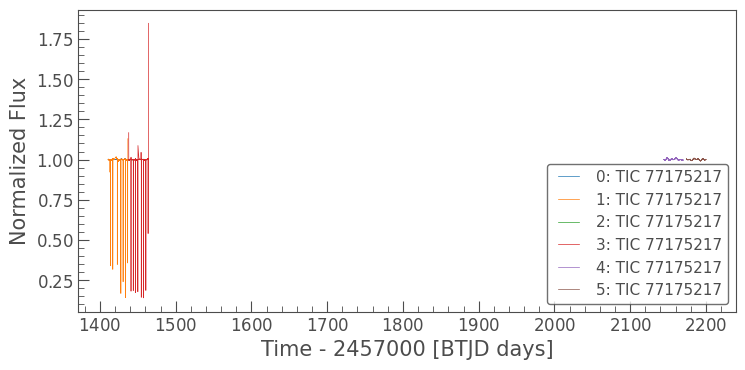

In [5]:
lc.plot(normalize=True);

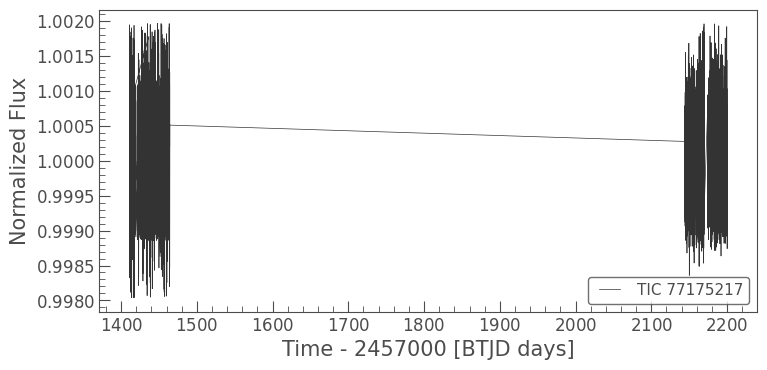

In [6]:
# Flatten the light curve
lc_flat = lc.stitch().flatten(window_length=901).remove_outliers()
lc_flat.plot();

(1410.0, 1470.0)

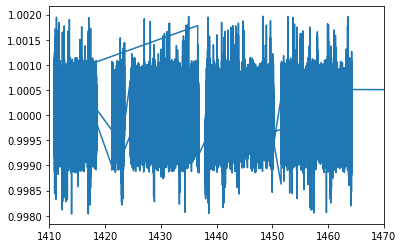

In [8]:
plt.plot(lc_flat.time.btjd,lc_flat.flux)
#plt.xlim(1755,1756)
plt.xlim(1410,1470)

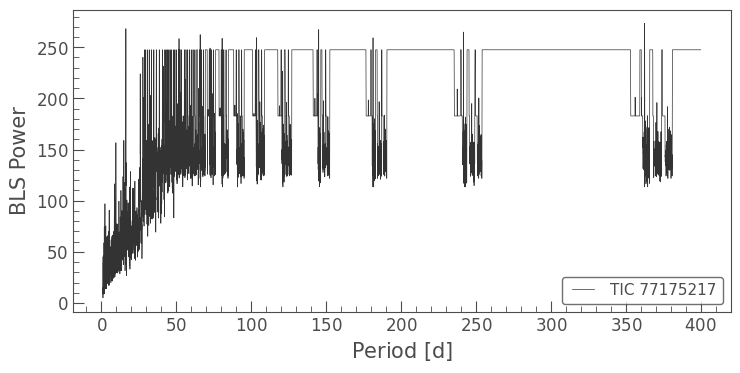

In [9]:
# Create array of periods to search
period = np.linspace(1, 400, 10000)
# Create a BLSPeriodogram
bls = lc_flat.to_periodogram(method='bls', period=period, frequency_factor=500);
bls.plot();

In [10]:
planet_period = bls.period_at_max_power
planet_t0 = bls.transit_time_at_max_power
planet_dur = bls.duration_at_max_power

# Check the value for period
planet_period

<Quantity 362.53015302 d>

In [11]:
planet_t0.value

1438.188905972686

In [12]:
planet_period.value

362.53015301530155

In [13]:
bls.depth_at_max_power

<Quantity 0.00050912>

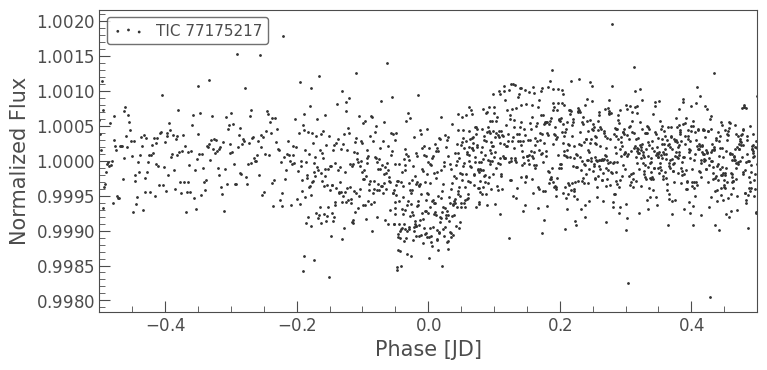

In [22]:
ax = lc_flat.fold(period=planet_period, epoch_time=planet_t0).scatter()
ax.set_xlim(-.5, .5);

In [16]:
# Create a cadence mask using the BLS parameters
planet_mask = bls.get_transit_mask(period=planet_period,
                                     transit_time=planet_t0,
                                     duration=planet_dur)

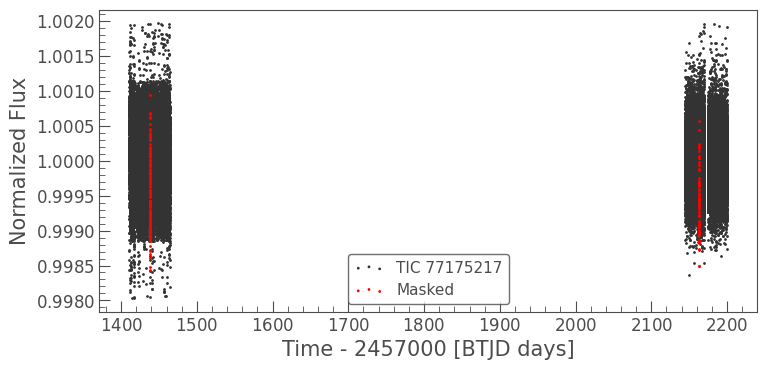

In [18]:
masked_lc = lc_flat[~planet_mask]
ax = masked_lc.scatter();
lc_flat[planet_mask].scatter(ax=ax, c='r', label='Masked');
#ax.set_xlim(2783.5,2784);

In [19]:
# Create a BLS model using the BLS parameters
planet_model = bls.get_transit_model(period=planet_period,
                                       transit_time=planet_t0,
                                       duration=planet_dur)

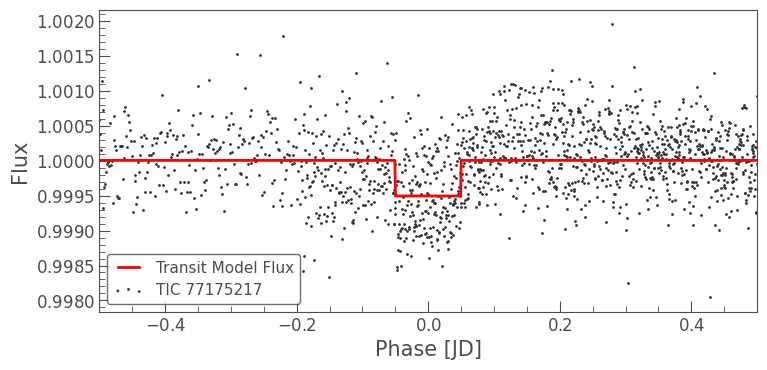

In [21]:
ax = lc_flat.fold(planet_period, planet_t0).scatter()
planet_model.fold(planet_period, planet_t0).plot(ax=ax, c='r', lw=2)
ax.set_xlim(-.5, .5);

In [ ]:
lc_flat.interact_bls()

Extra planet signals?

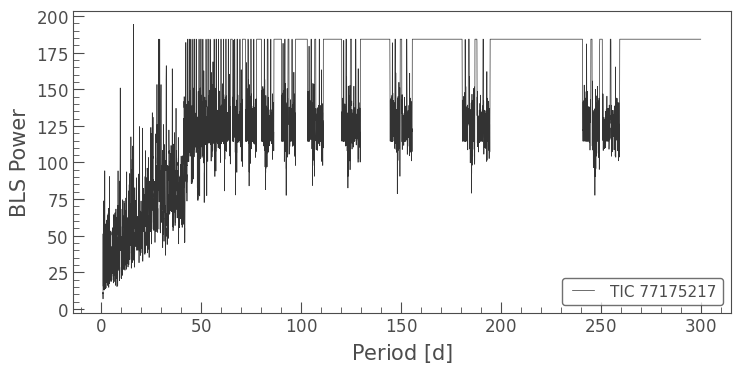

In [23]:
period2 = np.linspace(1, 300, 10000)
bls2 = masked_lc.to_periodogram('bls', period=period2, frequency_factor=500)
bls2.plot();

In [24]:
planet_c_period = bls2.period_at_max_power
planet_c_t0 = bls2.transit_time_at_max_power
planet_c_dur = bls2.duration_at_max_power

# Check the value for period
planet_c_period

<Quantity 16.34023402 d>

<AxesSubplot:xlabel='Phase [JD]', ylabel='Flux'>

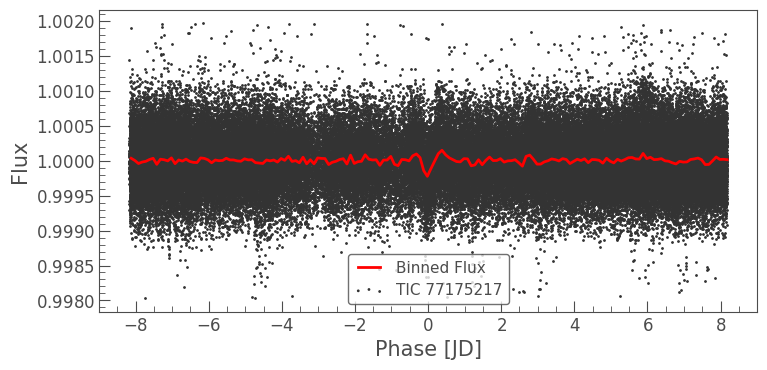

In [25]:
ax = masked_lc.fold(planet_c_period, planet_c_t0).scatter()
masked_lc.fold(planet_c_period, planet_c_t0).bin(.1).plot(ax=ax, c='r', lw=2,
                                                          label='Binned Flux')
#ax.set_xlim(-5, 5);

In [26]:
planet_c_model = bls.get_transit_model(period=planet_c_period,
                                       transit_time=planet_c_t0,
                                       duration=planet_c_dur)

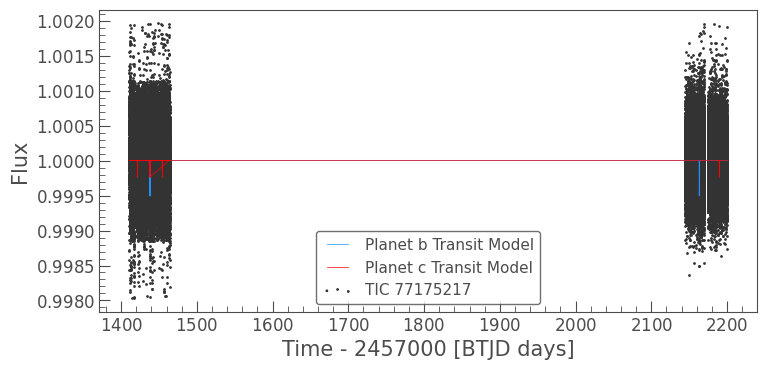

In [27]:
ax = lc_flat.scatter();
planet_model.plot(ax=ax, c='dodgerblue', label='Planet b Transit Model');
planet_c_model.plot(ax=ax, c='r', label='Planet c Transit Model');

(1435.0, 1440.0)

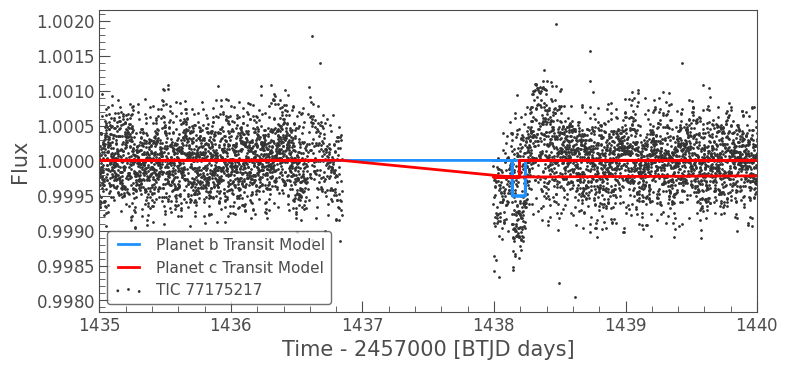

In [30]:
ax = lc_flat.scatter();
planet_model.plot(ax=ax, c='dodgerblue', label='Planet b Transit Model',lw=2);
planet_c_model.plot(ax=ax, c='r', label='Planet c Transit Model',lw=2);
#ax.set_xlim(1420,1424)

ax.set_xlim(1435,1440)

Fitting a transit model using the exoplanet/PyMC3 framework: https://gallery.exoplanet.codes/tutorials/transit/#the-transit-model-in-pymc3

In [33]:
import pymc3 as pm
import pymc3_ext as pmx

In [50]:
from celerite2.theano import terms, GaussianProcess

In [38]:
print(planet_period,planet_c_period)

55.01980198019802 d 17.028002800280028 d


In [67]:
np.log(bls.depth_at_max_power)

<Quantity -5.30192877>

In [85]:
periods = [55.01980198019802,17.028002800280028]
t0s = periods * np.random.rand(2)
t = lc_flat.time.btjd
y=lc_flat.flux.value
yerr = lc_flat.flux_err.value

In [89]:
t0s

array([50.72938191,  3.41286816])

In [70]:
bls_depth = bls.depth_at_max_power
bls_depth

<Quantity 0.00498198>

In [51]:
phase_lc = np.linspace(-0.2, 0.2, 100)

In [88]:
with pm.Model() as model:

    # The baseline flux
    mean = pm.Normal("mean", mu=0.0, sd=1.0)

    # The time of a reference transit for each planet
    t0 = pm.Normal("t0", mu=t0s, sd=1.0, shape=2)

    # The log period; also tracking the period itself
    logP = pm.Normal("logP", mu=np.log(periods), sd=0.1, shape=2)
    period = pm.Deterministic("period", pm.math.exp(logP))

    # The Kipping (2013) parameterization for quadratic limb darkening paramters
    u = xo.distributions.QuadLimbDark("u", testval=np.array([0.3, 0.2]))

    r = pm.Uniform(
        "r", lower=0.01, upper=0.1, shape=2, testval=np.array([0.04, 0.06])
    )
    b = xo.distributions.ImpactParameter(
        "b", ror=r, shape=2, testval=np.random.rand(2)
    )

    # Set up a Keplerian orbit for the planets
    orbit = xo.orbits.KeplerianOrbit(period=period, t0=t0, b=b)

    # Compute the model light curve using starry
    light_curves = xo.LimbDarkLightCurve(u[0], u[1]).get_light_curve(orbit=orbit, r=r, t=t)
    light_curve = pm.math.sum(light_curves, axis=-1) + mean

    # Here we track the value of the model light curve for plotting purposes
    pm.Deterministic("light_curves", light_curves)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=light_curve, sd=yerr, observed=y)

    # Fit for the maximum a posteriori parameters given the simuated
    # dataset
    map_soln = pmx.optimize(start=model.test_point)

INFO (theano.gof.compilelock): Refreshing lock /Users/lupitatovar/.theano/compiledir_Darwin-20.6.0-x86_64-i386-64bit-i386-3.7.9-64/lock_dir/lock


TypeError: Join cannot handle arguments of dimension 0. For joining scalar values, see @stack

In [87]:
def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones(len(t), dtype=bool)
        
    with pm.Model() as model:
        # Parameters for the stellar properties
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        u_star = xo.QuadLimbDark("u_star")
        star = xo.LimbDarkLightCurve(u_star)

        # Stellar parameters from TFOP
        M_star = 0.286,0.020
        R_star = 0.308,0.009
        BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=3)
        m_star = BoundedNormal(
            "m_star", mu=M_star[0], sd=M_star[1]
        )
        r_star = BoundedNormal(
            "r_star", mu=R_star[0], sd=R_star[1]
        )

        # Orbital parameters for the planets
        t0 = pm.Normal("t0", mu=planet_t0.value, sd=1)
        log_period = pm.Normal("log_period", mu=np.log(planet_period.value), sd=1)
        period = pm.Deterministic("period", pm.math.exp(log_period))

        # Fit in terms of transit depth (assuming b<1)
        b = pm.Uniform("b", lower=0, upper=2)
        log_depth = pm.Normal("log_depth", mu=np.log(bls_depth), sigma=2.0)
        ror = pm.Deterministic(
            "ror",
            star.get_ror_from_approx_transit_depth(
                1e-3 * pm.math.exp(log_depth), b
            ),
        )
        r_pl = pm.Deterministic("r_pl", ror * r_star)
        
        ecs = pmx.UnitDisk("ecs", testval=np.array([0.01, 0.0]))
        ecc = pm.Deterministic("ecc", pm.math.sum(ecs**2))
        omega = pm.Deterministic("omega", pm.math.arctan2(ecs[1], ecs[0]))
        xo.eccentricity.kipping13("ecc_prior", fixed=True, observed=ecc)

        # Transit jitter & GP parameters
        log_sigma_lc = pm.Normal(
            "log_sigma_lc", mu=np.log(np.std(y[mask])), sd=10
        )
        log_rho_gp = pm.Normal("log_rho_gp", mu=0, sd=10)
        log_sigma_gp = pm.Normal(
            "log_sigma_gp", mu=np.log(np.std(y[mask])), sd=10
        )

        # Orbit model
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star,
            m_star=m_star,
            period=period,
            t0=t0,
            b=b,
            ecc=ecc,
            omega=omega,
        )

        # Compute the model light curve
        light_curves = (
            star.get_light_curve(orbit=orbit, r=r_pl, t=t[mask], texp=texp)
            * 1e3
        )
        light_curve = pm.math.sum(light_curves, axis=-1) + mean
        resid = y[mask] - light_curve

        # GP model for the light curve
        kernel = terms.SHOTerm(
            sigma=pm.math.exp(log_sigma_gp),
            rho=pm.math.exp(log_rho_gp),
            Q=1 / np.sqrt(2),
        )
        gp = GaussianProcess(kernel, t=t[mask], yerr=pm.math.exp(log_sigma_lc))
        gp.marginal("gp", observed=resid)
        #         pm.Deterministic("gp_pred", gp.predict(resid))

        # Compute and save the phased light curve models
        pm.Deterministic(
            "lc_pred",
            1e3
            * star.get_light_curve(
                orbit=orbit, r=r_pl, t=t0 + phase_lc, texp=texp
            )[..., 0],
        )

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = pmx.optimize(
            start=start, vars=[log_sigma_lc, log_sigma_gp, log_rho_gp]
        )
        map_soln = pmx.optimize(start=map_soln, vars=[log_depth])
        map_soln = pmx.optimize(start=map_soln, vars=[b])
        map_soln = pmx.optimize(start=map_soln, vars=[log_period, t0])
        map_soln = pmx.optimize(start=map_soln, vars=[u_star])
        map_soln = pmx.optimize(start=map_soln, vars=[log_depth])
        map_soln = pmx.optimize(start=map_soln, vars=[b])
        map_soln = pmx.optimize(start=map_soln, vars=[ecs])
        map_soln = pmx.optimize(start=map_soln, vars=[mean])
        map_soln = pmx.optimize(
            start=map_soln, vars=[log_sigma_lc, log_sigma_gp, log_rho_gp]
        )
        map_soln = pmx.optimize(start=map_soln)

        extras = dict(
            zip(
                ["light_curves", "gp_pred"],
                pmx.eval_in_model([light_curves, gp.predict(resid)], map_soln),
            )
        )

    return model, map_soln, extras
model0, map_soln0, extras0 = build_model()

['/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/include', '/Users/lupitatovar/anaconda3/lib/python3.7/site-packages/exoplanet/theano_ops/lib/vendor/eigen-3.3.7']


AssertionError: 

NameError: name 'map_soln' is not defined

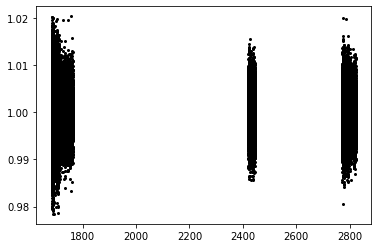

In [43]:
plt.plot(t, lc_flat.flux, ".k", ms=4, label="data")
for i, l in enumerate("bc"):
    plt.plot(
        t, map_soln["light_curves"][:, i], lw=1, label="planet {0}".format(l)
    )
plt.xlim(t.min(), t.max())
plt.ylabel("relative flux")
plt.xlabel("time [days]")
plt.legend(fontsize=10)
_ = plt.title("map model")